In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the path to your dataset
base_dir = r'C:\Users\rithv\OneDrive\Desktop\cnn_rnn_models\sca2_dti_cnn\ses1_model_anat\implem'  # Update with the path to your dataset

# Set up ImageDataGenerators for training and validation sets
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Rescale the pixel values from [0, 255] to [0, 1]
    rotation_range=40,          # Degree range for random rotations
    width_shift_range=0.2,      # Range (as a fraction of total width) for horizontal shifts
    height_shift_range=0.2,     # Range (as a fraction of total height) for vertical shifts
    shear_range=0.2,            # Shearing range
    zoom_range=0.2,             # Zoom range
    horizontal_flip=True,       # Randomly flip inputs horizontally
    validation_split=0.2        # Fraction of images reserved for validation
)

# Prepare iterators for training and validation
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(256, 256),     # Resize images to 256x256
    batch_size=32,
    class_mode='binary',        # Use 'binary' for binary classification, 'categorical' for multi-class
    subset='training'           # Specify as training data
)

validation_generator = train_datagen.flow_from_directory(

    base_dir,
    target_size=(256, 256),     # Resize images to 256x256
    batch_size=32,
    class_mode='binary',        # Use 'binary' for binary classification, 'categorical' for multi-class
    subset='validation'         # Specify as validation data
)

Found 3311 images belonging to 2 classes.
Found 826 images belonging to 2 classes.


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D, GlobalAveragePooling2D, Dense, Add
from tensorflow.keras.models import Model

# Define the ResNet-18 architecture
def residual_block(x, filters, strides=1):
    # Shortcut path
    shortcut = x
    
    # First convolution layer
    x = Conv2D(filters, kernel_size=(3, 3), strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    # Second convolution layer
    x = Conv2D(filters, kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    
    # Shortcut connection
    if strides != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=(1, 1), strides=strides, padding='same')(shortcut)
    
    # Add the shortcut to the output
    x = Add()([x, shortcut])
    x = ReLU()(x)
    
    return x

# Input layer
input_layer = Input(shape=(224, 224, 3))

# Initial convolution layer
x = Conv2D(64, kernel_size=(7, 7), strides=2, padding='same')(input_layer)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

# Residual blocks
x = residual_block(x, filters=64)
x = residual_block(x, filters=64)
x = residual_block(x, filters=128, strides=2)
x = residual_block(x, filters=128)
x = residual_block(x, filters=256, strides=2)
x = residual_block(x, filters=256)
x = residual_block(x, filters=512, strides=2)
x = residual_block(x, filters=512)

# Global average pooling
x = GlobalAveragePooling2D()(x)

# Output layer (binary classification)
output_layer = Dense(1, activation='sigmoid')(x)

# Create the ResNet-18 model
resnet18_model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
resnet18_model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

# Display model summary
resnet18_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 64)         9472      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 112, 112, 64)         0         ['batch_normalization[0][0

In [3]:
# Train the model
history = resnet18_model.fit(
    train_generator,
    epochs=30,  # You can adjust the number of epochs as needed
    validation_data=validation_generator
)

Epoch 1/30
104/104 [==============================] - 440s 4s/step - loss: 0.6365 - accuracy: 0.6995 - val_loss: 3.2355 - val_accuracy: 0.6937
Epoch 2/30
104/104 [==============================] - 389s 4s/step - loss: 0.4286 - accuracy: 0.8031 - val_loss: 0.7718 - val_accuracy: 0.6768
Epoch 3/30
104/104 [==============================] - 398s 4s/step - loss: 0.3592 - accuracy: 0.8405 - val_loss: 1.2937 - val_accuracy: 0.6283
Epoch 4/30
104/104 [==============================] - 399s 4s/step - loss: 0.2974 - accuracy: 0.8710 - val_loss: 3.2042 - val_accuracy: 0.7191
Epoch 5/30
104/104 [==============================] - 403s 4s/step - loss: 0.2618 - accuracy: 0.8925 - val_loss: 8.0645 - val_accuracy: 0.3075
Epoch 6/30
104/104 [==============================] - 428s 4s/step - loss: 0.2262 - accuracy: 0.9009 - val_loss: 5.0422 - val_accuracy: 0.6937
Epoch 7/30
104/104 [==============================] - 388s 4s/step - loss: 0.2144 - accuracy: 0.9052 - val_loss: 16.9066 - val_accuracy: 0.308

In [4]:
resnet18_model.save('resnet18_30epoch_att2.keras')

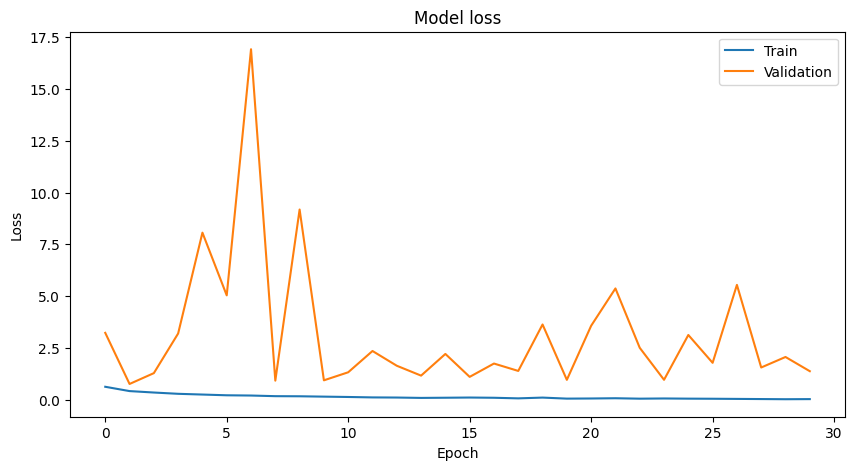

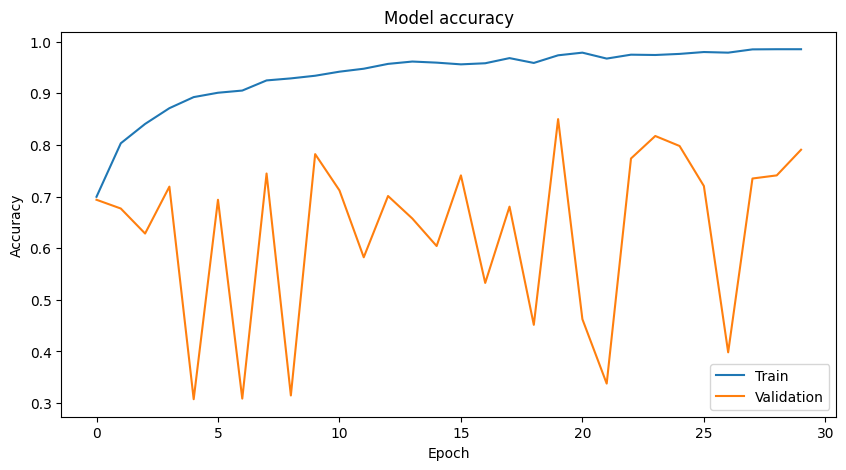

In [5]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [13]:
import cv2
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from IPython.display import Image, display
import os

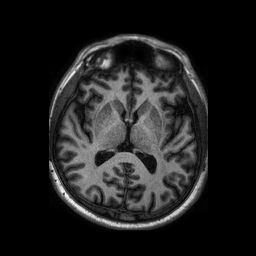

In [14]:

preprocess_input = tf.keras.applications.xception.preprocess_input
decode_predictions = tf.keras.applications.xception.decode_predictions

img_size = (224, 224)

# img_path = r'C:\Users\rithv\OneDrive\Desktop\cnn_rnn_models\sca2_dti_cnn\ses1_model_anat\test\test2.jpg'

img_path = r'C:\Users\rithv\OneDrive\Desktop\cnn_rnn_models\sca2_dti_cnn\ses1_model_anat\implem\control_ses1\ses-01_sub-control11_ses-01_T1w.nii_slice_78_axial.png'




last_conv_layer_name = 'conv2d'

display(Image(img_path))

In [15]:
def load_img(img_path, size=None):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    img = tf.keras.preprocessing.image.img_to_array(img)
    return img


def get_img_array(img_path, size):
    img_array = load_img(img_path, size)
    # We add a dimension to transform our array into a 'batch'
    # of size (1, 299, 299, 3)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array


def get_preprocessed_img(img_path, size):
    img_array = get_img_array(img_path, size)
    return preprocess_input(img_array)

In [16]:
def generate_cam(img_array, model, last_conv_layer_name, pred_index=None, respond=False):
    """
    Generates a Class Activation Map (CAM) for a given image and model.

    Args:
        img_array (numpy.array): The input image in array format.
        model (tf.keras.Model): The trained model.
        last_conv_layer_name (str): The name of the last convolutional layer.
        pred_index (int, optional): Index of the predicted class. Defaults to None.
        respond (bool, optional): Whether to use Respond-CAM. Defaults to False.

    Returns:
        numpy.array: The generated heatmap as an array.
    """
    # Creating a model that maps the input image to the activations
    try:
        grad_model = tf.keras.models.Model(
            [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
        )
    except ValueError as e:
        raise ValueError("Invalid last_conv_layer_name: " + str(e))

    # Computing the gradient
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    conv_outputs = conv_outputs[0]

    if respond:
        # Calculation for Respond-CAM
        respond_weights = np.sum(conv_outputs * grads, axis=(0, 1, 2)) / \
            (np.sum(conv_outputs + 1e-10, axis=(0, 1, 2)))
        heatmap = conv_outputs * respond_weights
    else:
        # Default HiResCAM calculation
        heatmap = conv_outputs * grads

    heatmap = np.sum(heatmap, axis=-1)
    heatmap = tf.squeeze(heatmap)

    # Normalizing the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


1/1 [==============================] - 0s 57ms/step


Predicted: [[-40.721592]]


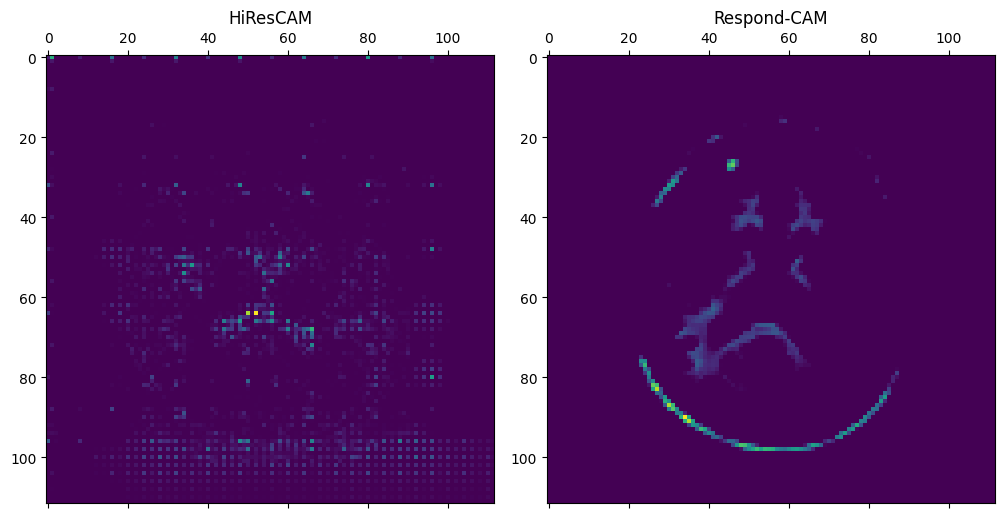

In [17]:
img_array = get_preprocessed_img(img_path, size=img_size)
resnet18_model.layers[-1].activation = None

# Print what the top predicted class is
preds = resnet18_model.predict(img_array)
print('Predicted:', preds)

# Generate class activation heatmap
heatmap = generate_cam(img_array, resnet18_model, last_conv_layer_name)
respond_heatmap = generate_cam(
    img_array, resnet18_model, last_conv_layer_name, respond=True)

# Display heatmap
fig = plt.figure(constrained_layout=True, figsize=(10, 5))
axes = fig.subplots(1, 2)

axes[0].set_title('HiResCAM')
axes[0].matshow(heatmap)
axes[1].set_title('Respond-CAM')
axes[1].matshow(respond_heatmap)
plt.show()

In [22]:
def resize_heatmap(img_path, heatmap):
    # Load the original image
    img = load_img(img_path)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap('jet')

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    return jet_heatmap

In [23]:
resized_heatmap = resize_heatmap(img_path, heatmap)
resized_respond_heatmap = resize_heatmap(img_path, respond_heatmap)

C:\Users\rithv\AppData\Local\Temp\ipykernel_234368\3870767909.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap('jet')


In [24]:
def visualize_side_by_side(hirescam_img, respondcam_img):
    fig = plt.figure(constrained_layout=True, figsize=(20, 10))
    axes = fig.subplots(1, 2)

    axes[0].set_title('HiResCAM')
    axes[0].imshow(hirescam_img)
    axes[1].set_title('Respond-CAM')
    axes[1].imshow(respondcam_img)
    plt.show()

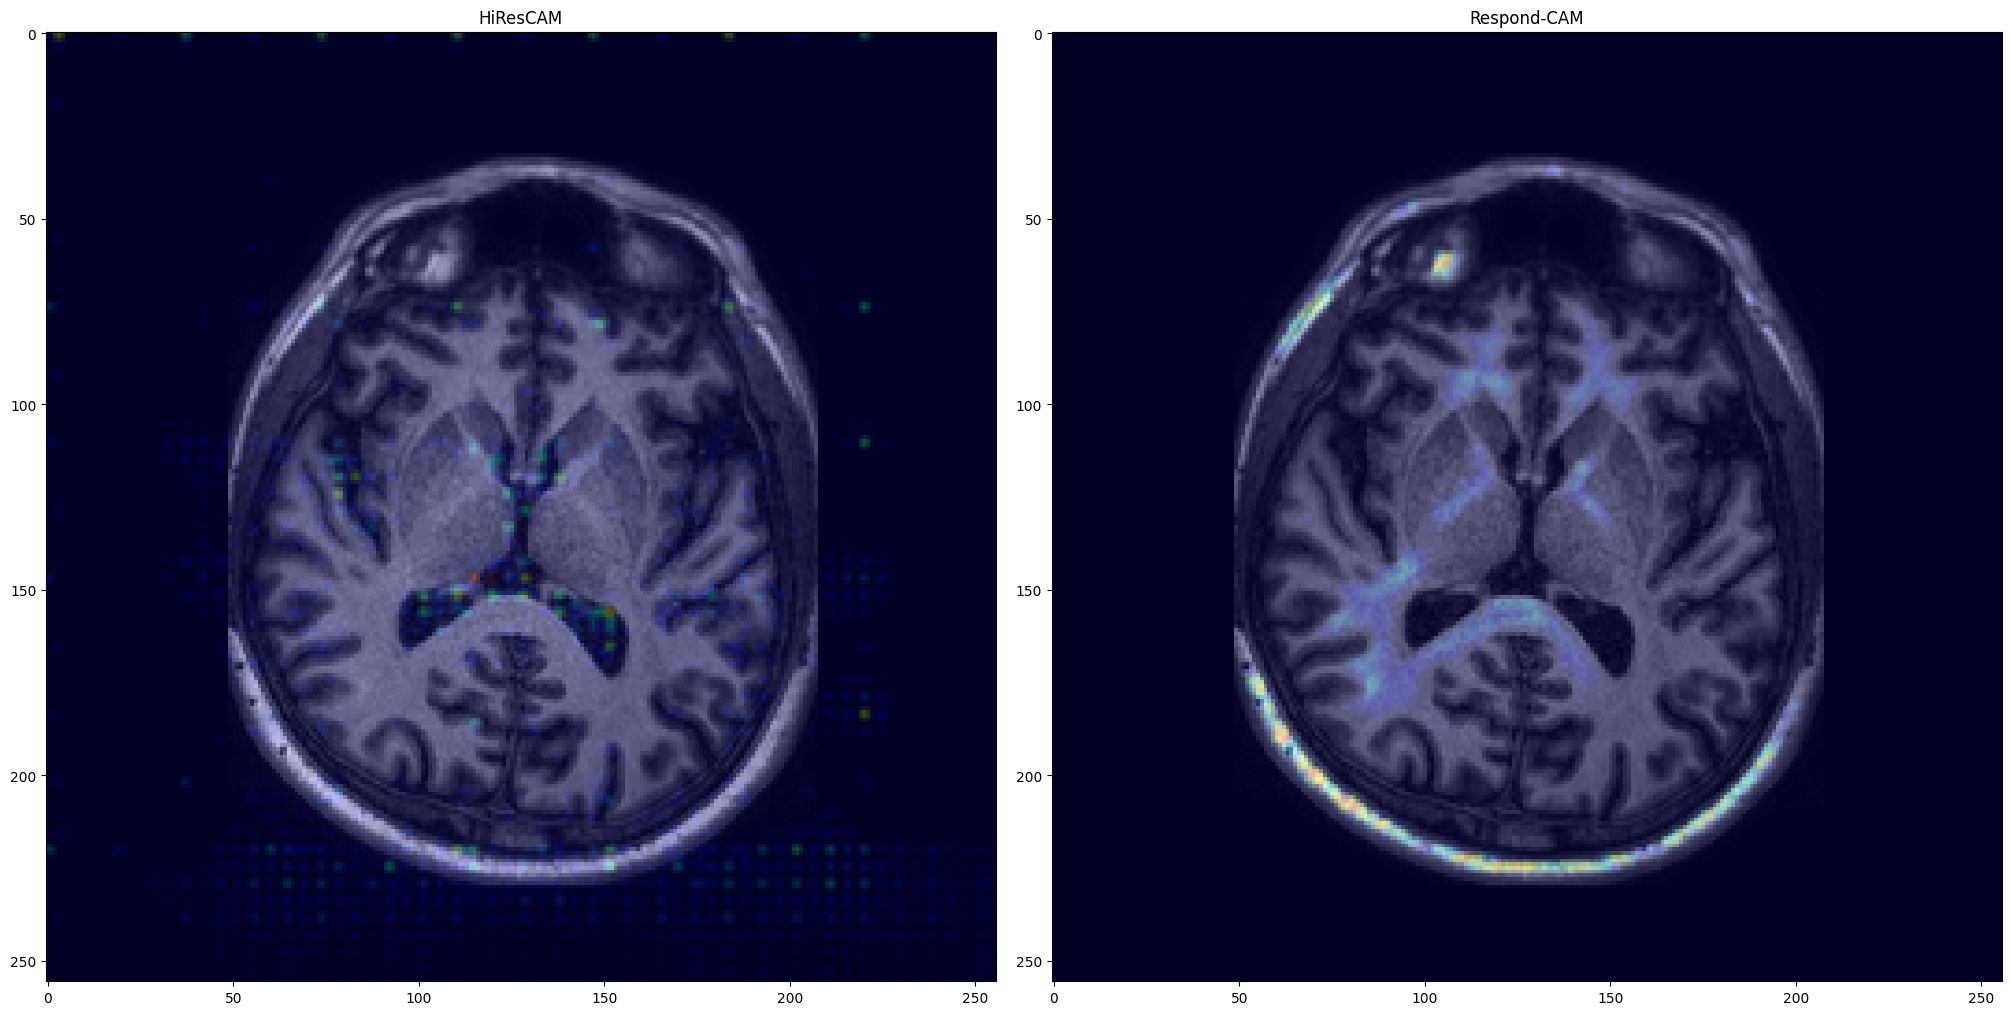

In [25]:
def superimpose_heatmap(img, heatmap, alpha=0.4):
    superimposed_img = heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(
        superimposed_img)

    return superimposed_img


original_img = load_img(img_path)
superimposed_img = superimpose_heatmap(original_img, resized_heatmap)
superimposed_respond_img = superimpose_heatmap(
    original_img, resized_respond_heatmap)

visualize_side_by_side(superimposed_img, superimposed_respond_img)